In [27]:
import pandas as pd
import os
from typing import List
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
go_file = "/Users/kajolpatel/Desktop/Individual_Project/poc/go-basic.obo"

### Parse the Dataset

In [5]:
def parse_obo_file(file_path):
    
    data = []
    current_term = {}
    in_term_block = False
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == '[Term]':  #starting a new term block
                if current_term:
                    data.append(current_term)
                current_term = {}
                in_term_block = True
            elif line == '':
                in_term_block = False  #end of a term block
            elif in_term_block:
                if ': ' in line:
                    key, value = line.split(': ', 1)
                    if key in current_term:  #handling multiple lines of the same key
                        if isinstance(current_term[key], list):
                            current_term[key].append(value)
                        else:
                            current_term[key] = [current_term[key], value]
                    else:
                        current_term[key] = value

    
    if current_term: #add the last term if file does not end with a newline
        data.append(current_term)

    return pd.DataFrame(data)

df = parse_obo_file(go_file)


In [6]:
#ypdating 'def' column to 'definition'
df = df.rename(columns={'def': 'definition'}) 

In [7]:
df.head(4)

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","""mitochondrial inheritance"" EXACT []","[GO:0048308 ! organelle inheritance, GO:004831...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,GO:0007005 ! mitochondrion organization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0000003,obsolete reproduction,biological_process,"""OBSOLETE. The production of new individuals t...","""reproductive physiological process"" EXACT []",NaN,"[GO:0019952, GO:0050876]",The reason for obsoletion is that this term is...,true,GO:0022414,NaN,NaN,NaN,NaN
3,GO:0000005,obsolete ribosomal chaperone activity,molecular_function,"""OBSOLETE. Assists in the correct assembly of ...","""ribosomal chaperone activity"" EXACT []",NaN,NaN,This term was made obsolete because it refers ...,true,NaN,"[GO:0042254, GO:0044183, GO:0051082]",NaN,NaN,NaN


In [8]:
df['id'].nunique()

47856

In [9]:
df.namespace.nunique()

3

In [10]:
df.namespace.value_counts()


namespace
biological_process    30723
molecular_function    12614
cellular_component     4519
Name: count, dtype: int64

In [11]:
df[df.is_obsolete == 'true']

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
2,GO:0000003,obsolete reproduction,biological_process,"""OBSOLETE. The production of new individuals t...","""reproductive physiological process"" EXACT []",NaN,"[GO:0019952, GO:0050876]",The reason for obsoletion is that this term is...,true,GO:0022414,NaN,NaN,NaN,NaN
3,GO:0000005,obsolete ribosomal chaperone activity,molecular_function,"""OBSOLETE. Assists in the correct assembly of ...","""ribosomal chaperone activity"" EXACT []",NaN,NaN,This term was made obsolete because it refers ...,true,NaN,"[GO:0042254, GO:0044183, GO:0051082]",NaN,NaN,NaN
6,GO:0000008,obsolete thioredoxin,molecular_function,"""OBSOLETE. A small disulfide-containing redox ...","""thioredoxin"" EXACT []",NaN,GO:0000013,This term was made obsolete because it represe...,true,NaN,"[GO:0003756, GO:0015036]",NaN,NaN,NaN
17,GO:0000020,obsolete negative regulation of recombination ...,biological_process,"""OBSOLETE. Any process that stops, prevents, o...","""negative regulation of recombination within r...",NaN,NaN,This term was made obsolete because it describ...,true,NaN,GO:0045950,NaN,NaN,NaN
33,GO:0000039,obsolete plasma membrane long-chain fatty acid...,molecular_function,"""OBSOLETE. (Was not defined before being made ...","""plasma membrane long-chain fatty acid transpo...",NaN,NaN,This term was made obsolete because it describ...,true,NaN,"[GO:0005324, GO:0005886]",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47792,GO:2001254,obsolete negative regulation of histone H3-K36...,biological_process,"""OBSOLETE. Any process that stops, prevents or...",NaN,NaN,NaN,This term was obsoleted because it represents ...,true,NaN,GO:0006338,NaN,NaN,NaN
47793,GO:2001255,obsolete positive regulation of histone H3-K36...,biological_process,"""OBSOLETE. Any process that activates or incre...",NaN,NaN,NaN,This term was obsoleted because it represents ...,true,NaN,GO:0140673,NaN,NaN,NaN
47811,GO:2001273,obsolete regulation of glucose import in respo...,biological_process,"""OBSOLETE. Any process that modulates the freq...","""regulation of cellular glucose import in resp...",NaN,NaN,This term was obsoleted because it represents ...,true,NaN,NaN,NaN,NaN,NaN
47812,GO:2001274,obsolete negative regulation of glucose import...,biological_process,"""OBSOLETE. Any process that stops, prevents or...","""negative regulation of cellular glucose impor...",NaN,NaN,NaN,true,NaN,NaN,NaN,NaN,NaN


In [12]:
df[df.is_obsolete.isna() == True]

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","""mitochondrial inheritance"" EXACT []","[GO:0048308 ! organelle inheritance, GO:004831...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,GO:0007005 ! mitochondrion organization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...","[""high affinity zinc uptake transmembrane tran...",GO:0005385 ! zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",NaN,GO:0005385 ! zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0000009,"alpha-1,6-mannosyltransferase activity",molecular_function,"""Catalysis of the transfer of a mannose residu...","""1,6-alpha-mannosyltransferase activity"" EXACT []",GO:0000030 ! mannosyltransferase activity,NaN,NaN,NaN,NaN,NaN,"Reactome:R-HSA-449718 ""Addition of a third man...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47851,GO:2001313,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways involving...","""UDP-4-deoxy-4-formamido-beta-L-arabinopyranos...","[GO:0006040 ! amino sugar metabolic process, G...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47852,GO:2001314,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways resulting...","[""UDP-4-deoxy-4-formamido-beta-L-arabinopyrano...",[GO:0009227 ! nucleotide-sugar catabolic proce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47853,GO:2001315,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways resulting...","[""UDP-4-deoxy-4-formamido-beta-L-arabinopyrano...",[GO:0009226 ! nucleotide-sugar biosynthetic pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47854,GO:2001316,kojic acid metabolic process,biological_process,"""The chemical reactions and pathways involving...","[""5-hydroxy-2-(hydroxymethyl)-4H-pyran-4-one m...",[GO:0034308 ! primary alcohol metabolic proces...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Remove obsolete terms

In [13]:
df.is_obsolete.value_counts()

is_obsolete
true    5653
Name: count, dtype: int64

In [14]:
df = df[df.is_obsolete.isna() == True]

In [15]:
df.namespace.value_counts()

namespace
biological_process    27014
molecular_function    11132
cellular_component     4057
Name: count, dtype: int64

### Remove unnecessary columns

In [16]:
df = df[['id','namespace','definition']]

### CountVectorizer (removes stop words as well)

In [17]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.05)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
#creating a df with feature names as columns
X_df = pd.DataFrame(dense_X, columns=vectorizer.get_feature_names_out())

In [18]:
X_df.head(3)  #38093

,acid,activates,activity,ai,binding,catalysis,cell,cells,chemical,complex,...,process,protein,rate,reaction,reactions,reduces,resulting,rhea,stops,termgenie
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X_df.columns

Index(['acid', 'activates', 'activity', 'ai', 'binding', 'catalysis', 'cell',
       'cells', 'chemical', 'complex', 'dph', 'ec', 'extent', 'formation',
       'frequency', 'go_ref', 'goc', 'h2o', 'increases', 'isbn', 'mah',
       'membrane', 'modulates', 'movement', 'pathways', 'pmid', 'prevents',
       'process', 'protein', 'rate', 'reaction', 'reactions', 'reduces',
       'resulting', 'rhea', 'stops', 'termgenie'],
      dtype='object')

## KNN using Count Vectorizer

In [13]:
X_df.head(3)

,acid,activates,activity,ai,binding,catalysis,cell,cells,chemical,complex,...,process,protein,rate,reaction,reactions,reduces,resulting,rhea,stops,termgenie
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [130]:
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.9290368439758322 at K = 18


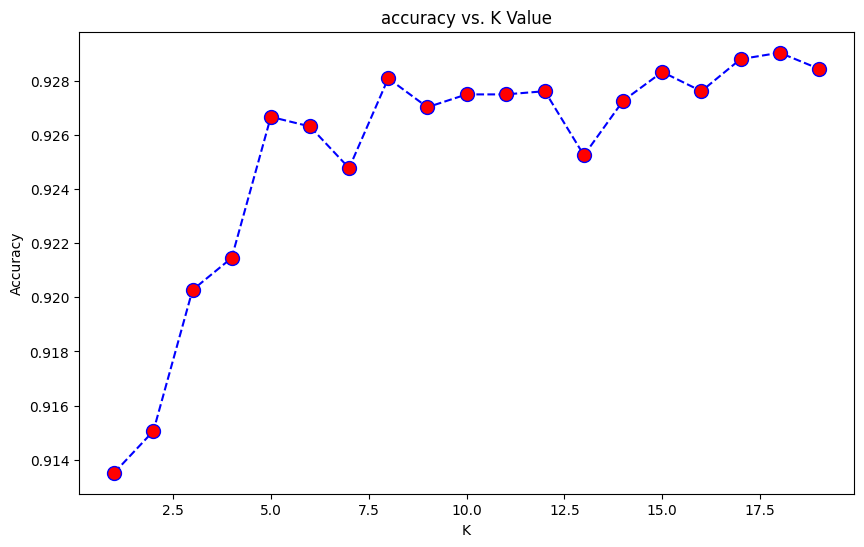

In [131]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)

In [132]:
neigh = KNeighborsClassifier(n_neighbors = 18).fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [133]:
confusion_matrix(y_test,y_pred)

array([[5229,  104,   39],
       [ 258,  540,   22],
       [ 104,   72, 2073]])

In [134]:
accuracy_score(y_test, y_pred)

0.9290368439758322

### KNN using CountVectorizer on Normalized data

In [135]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.05)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
scaler = StandardScaler()
X_normalized = scaler.fit_transform(dense_X)

In [138]:
X_normalized = pd.DataFrame(X_normalized, columns=vectorizer.get_feature_names_out())

In [136]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [114]:
confusion_matrix(y_test,y_pred)

array([[5208,   90,   74],
       [ 262,  510,   48],
       [  83,   48, 2118]])

In [115]:
accuracy_score(y_test,y_pred)

0.9283260277218339

In [144]:
acc = []
for i in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.9283260277218339 at K = 11


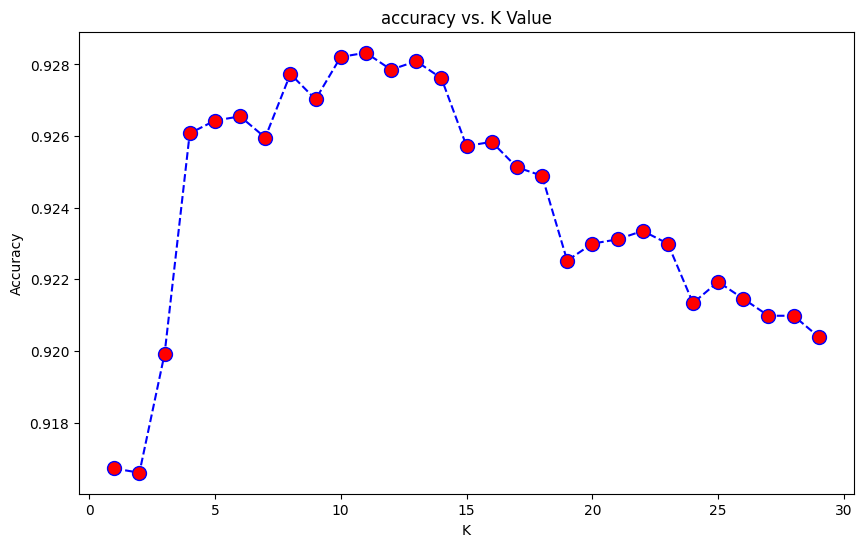

In [145]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc)) +1)

In [149]:
accuracy_score(y_test,y_pred)

0.9283260277218339

#### Exp with ignoring words that appear in less than 1 % definitions

In [118]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
X_df = pd.DataFrame(dense_X, columns=vectorizer.get_feature_names_out())

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [120]:
acc = []
for i in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.953560004738775 at K = 1


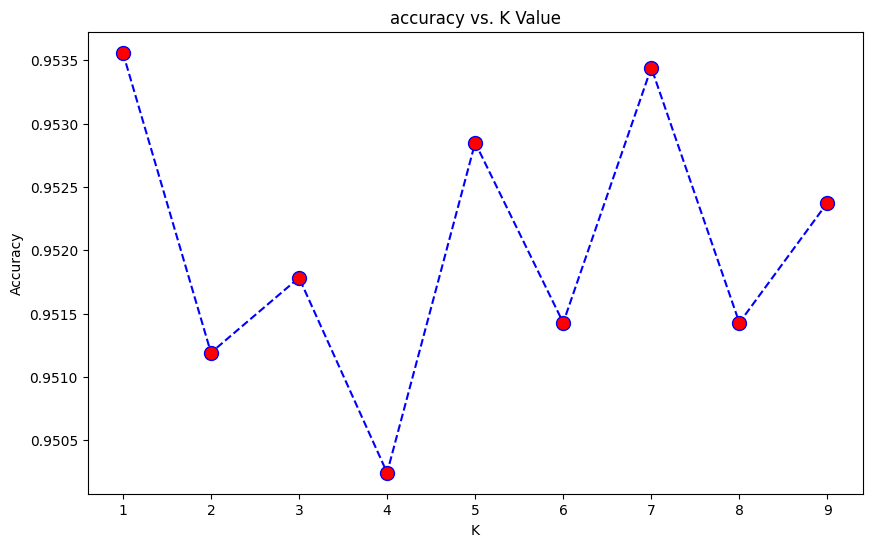

In [121]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)

In [122]:
max(acc)

0.953560004738775

### ignoring words that appear in less than 1 % definitions (normalized data)

In [150]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()


In [151]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(dense_X)
X_normalized = pd.DataFrame(X_normalized, columns=vectorizer.get_feature_names_out())

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [153]:
acc = []
for i in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.942305414050468 at K = 1


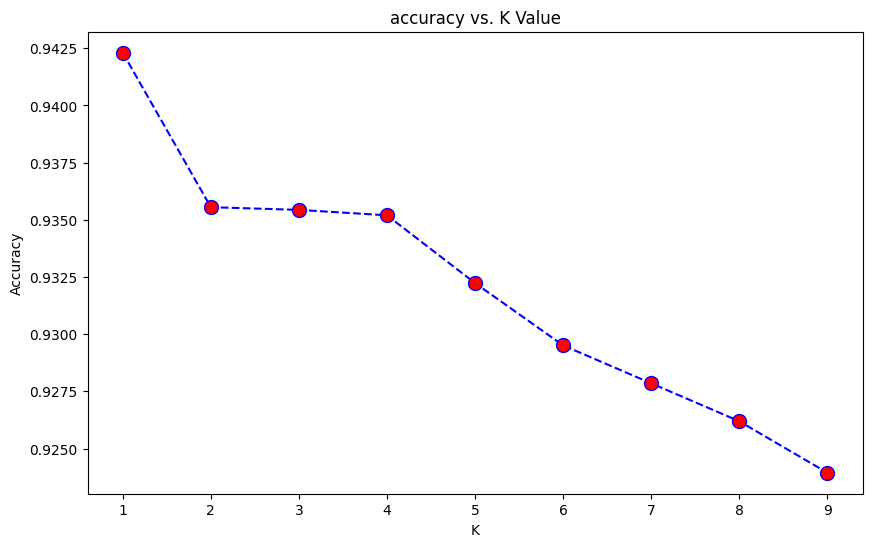

In [154]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)

- max accuracy with KNN using Count Vectorizer : 0.9290368439758322 (K = 18)
- max accuracy with KNN using CountVectorizer on Normalized data: 0.9283260277218339 (K = 11)
- max accuracy with KNN using CountVectorizer on ignoring words that do not appear in 1% of definitions: 0.953560004738775 (K = 1)
- max accuracy with KNN using CountVectorizer on Normalized data ignoring words that do not appear in 1% of definitions: 0.942305414050468 (K = 1)

### Support Vector Machines

In [28]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
X_df = pd.DataFrame(dense_X, columns=vectorizer.get_feature_names_out())
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [29]:
svm = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)


In [26]:
accuracy_score(y_test, y_pred)

0.9463333728231252

In [30]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=42),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [31]:
grid_search.best_estimator_

SVC(C=10, class_weight='balanced', random_state=42)

In [32]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


## KNN using TDIDF Vectorizer

In [47]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=0.05)

In [48]:
X_tfidf = tfidf_vectorizer.fit_transform(df['definition'])
dense_X_tfidf = X_tfidf.toarray()


In [49]:
scaler = StandardScaler()
X_normalized_tfidf = scaler.fit_transform(dense_X_tfidf)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized_tfidf, y, test_size=0.2, random_state=42)

In [51]:
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [52]:
accuracy_score(y_test,y_pred)

0.9273782727165027

In [53]:
confusion_matrix(y_pred,y_test)

array([[5193,  255,   91],
       [ 113,  528,   51],
       [  66,   37, 2107]])

In [59]:
acc = []
for i in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Text(0, 0.5, 'Accuracy')

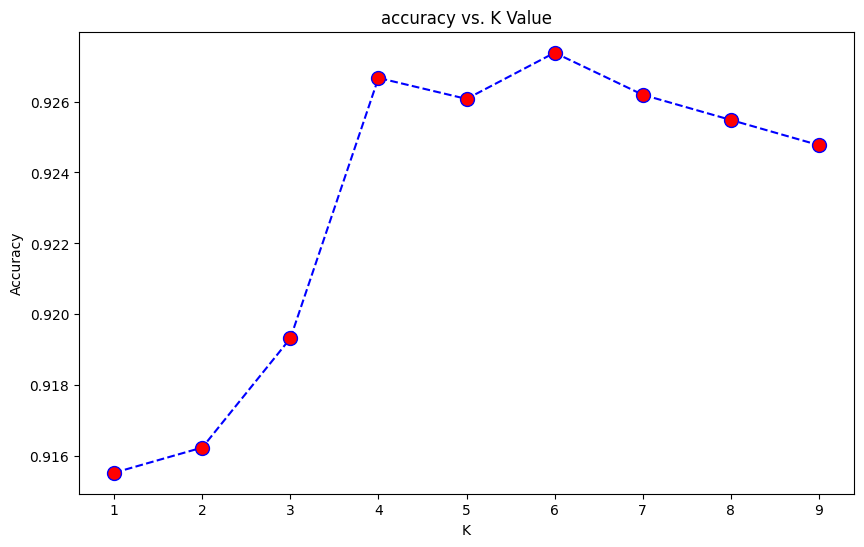

In [60]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

In [57]:
max(acc)

0.9273782727165027

KNN using tfidfvectoriuzer on Normalized data

In [ ]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(dense_X_tfidf)

### Method

1. Breakdown input text into feature set
2. Run KNN on definitions using feature set

##### Function to get feature set from an input text




In [76]:
"""
    Takes a paragraph 
"""
def get_feature_set_from_text(input_text: str)->List[str]:
    return []
